#### Propensity to Buy Model and Prediction (with XGBoost)

This project is part of series of classification Propensity to Buy models.  The series explores various appoaches to predict whether or not the customer is likely to make a purchase within a specified time period based on available historical data.

There are 78 original features in the data set, including the customer ID and Target variable.  Features include diverse information reflecting lifetime customer monetary value, spending patterns, response to email, and sms campaigns. In addition, customers are assigned RFM scores (Recency-Frequency - Monetary) for separate time periods within the year.  The separations were made heuristically by examining collective spending patterns, and the separate models were run for different time periods. In this module, I will work with a single time period with assigned rfm score.

Date variables, such as date of the first purchase, datae of the last purchase, etc., have been transformed into pipe variables - the difference in days from the selected anchor date.  The transformation was done outside of this script.

In this project, I will be modeling Propensity to Buy for a single chosen RFM period with an XGBoost classifier. XGBoost is one of the fastest implementations of gradient boosted trees. For each 'split', it uses inforomation about the distribution of features across all data points in a single 'leaf', and thus reduces the search space of possible feature splits. To find optimal hyperparameters, I will use cross-validated Bayes Search from the scikit-optimize (scopt) library.


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import xgboost as xgb
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer



In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [30]:
import warnings
warnings.filterwarnings("ignore")

#### 1. Read, process and explore the data: 


In [53]:

data = pd.read_csv('input_data.csv', header = 0)
df = data.copy()
df.shape

(10284, 74)

In [55]:
df.head()

,ID,nth_order,lifetime_revenue,lifetime_units,lifetime_margin,lifetime_discount_amt,aov,upt,avg_lag,net_nth_order,net_lifetime_revenue,net_lifetime_units,net_lifetime_margin,net_lifetime_discount_amt,net_aov,net_upt,direct_nth_order,direct_lifetime_revenue,direct_lifetime_units,direct_aov,retail_nth_order,retail_lifetime_revenue,retail_lifetime_units,retail_aov,first_30_day_spend,first_60_day_spend,first_90_day_spend,first_180_day_spend,first_360_day_spend,tot_ord_last_60,tot_ord_last_365,tot_spend_last_365,ordLast730,spendLast730,ordLast1095,spendLast1095,emFlg,emDel15Days,emDel30Days,emDel60Days,emClick15Days,emClick30Days,emClick60Days,smsDel15Days,smsDel30Days,smsDel60Days,smsClick15Days,smsClick30Days,smsClick60Days,dmDel15Days,dmDel30Days,dmDel60Days,csProdViews15Days,csProdViews30Days,csProdViews60Days,csCartAdds15Days,csCartAdds30Days,csCartAdds60Days,csAcctLogins15Days,csAcctLogins30Days,csAcctLogins60Days,csTimeOnSite15Days,csTimeOnSite30Days,csTimeOnSite60Days,rfm,acquisition_pipe,first_purchase_pipe,last_purchase_pipe,direct_first_purchase_pipe,direct_last_purchase_pipe,retail_first_purchase_pipe,retail_last_purchase_pipe,last_transaction_pipe,target
0,193646361,10,1652.54,23,1069.79,251.32,165.254000,2.300000,157.900000,10,1652.54,23,1080.58,251.32,165.254000,2.300000,3,462.20,5,46.220000,7,1190.34,18,119.034000,99.90,99.90,99.90,99.90,99.90,1,5,1075.55,9,1552.64,9,1552.64,1,14,27,44,0,2,4,1,2,5,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,5842,89172,89172,6,1594,1594,15,431,92,1594,15,15,0
1,219953872,13,1556.80,25,1050.01,64.78,119.753846,1.923077,131.538462,13,1152.48,21,555.57,19.90,88.652307,1.615385,12,1516.90,24,116.684615,1,39.90,1,3.069230,129.99,129.99,129.99,319.98,460.88,2,6,758.02,9,1046.42,10,1095.92,0,3,5,9,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,2,2,0,0,0,0,25447,25447,14,1728,1728,18,1728,18,628,628,18,0
2,201742579,8,1040.80,18,691.32,102.00,130.100000,2.250000,107.250000,8,726.60,15,394.84,102.00,90.825000,1.875000,4,632.70,13,79.087500,4,408.10,5,51.012500,89.60,89.60,89.60,189.50,289.40,1,4,592.20,7,951.20,8,1040.80,1,29,57,94,4,6,6,0,0,0,0,0,0,0,1,2,6,6,6,2,3,3,0,0,0,320288,522794,522794,10,858,858,0,858,0,700,166,0,0
3,216928500,9,1008.21,12,581.54,102.75,112.023333,1.333333,138.555556,8,751.23,9,424.48,74.75,83.470000,1.000000,9,1008.21,12,112.023333,0,0.00,0,0.000000,129.00,129.00,129.00,129.00,332.25,4,5,485.98,6,675.96,8,879.21,1,14,29,47,2,2,4,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,0,0,0,5193,678341758,678341758,5,1276,1276,29,1276,29,0,0,29,1
4,196615260,15,2355.48,23,1515.45,502.90,157.032000,1.533333,87.133333,15,2355.48,23,1512.40,502.90,157.032000,1.533333,8,880.33,14,58.688666,6,1306.15,8,87.076666,169.00,169.00,169.00,438.50,782.98,1,6,856.10,8,1273.85,12,1677.48,0,13,23,23,0,1,1,0,0,0,0,0,0,0,1,2,0,0,0,0,2,2,0,0,0,0,144018,144018,13,1333,1333,26,1045,26,1209,199,26,1


In [59]:
df['target'].value_counts()

target
0    7056
1    3228
Name: count, dtype: int64

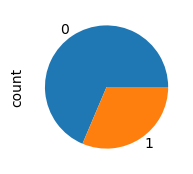

In [61]:
plt.figure(figsize = [2,2])
df['target'].value_counts().plot(kind = 'pie')
plt.show()

##### Plot RFM Score for buyers vs non-buyers for one of RFM scores (April - May):

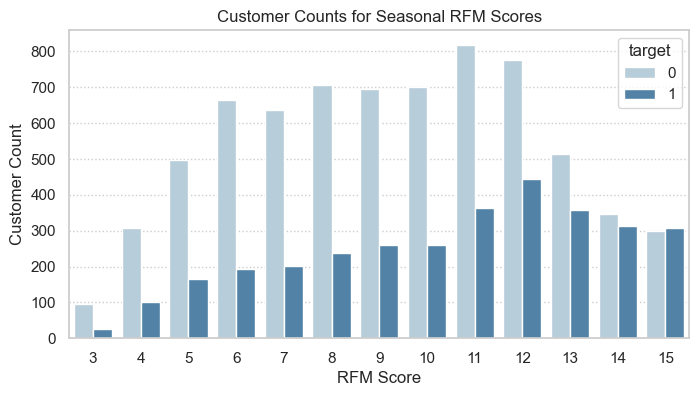

In [65]:

df['target'] = df['target'].astype('str')               # convert 'buy60' to string to avoid type error
sns.set(rc ={'figure.figsize': (8,4)})
sns.set_style('whitegrid', {'grid.linestyle':':'})
sns.countplot(data = df, x = 'rfm', hue = 'target', saturation = 0.6, palette = 'Blues')
plt.title('Customer Counts for Seasonal RFM Scores')
plt.ylabel('Customer Count')
plt.xlabel('RFM Score')
plt.show()

df['target'] = df['target'].astype('int64')             # convert 'buy60' back to int64

The plot shows that for April - May time period, as the RFM score goes up, the number of buyers vs non-buyers become closer.

In [67]:
#df: fill Nan values with 0 
df = df.fillna(0)


#### 2. Train the Model and Optimize Hyperparameters on Train Data:

In [70]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split



##### Define function for hyperparameters optimization:
The opimizeXGBoost function takes X_train and Y_train as arguments; optimizes hyperparameters for XGBoost classifier with 5X cross-validations logloss evaluation metric; fits the model with optimized parameters and produces best found F1 score.


In [73]:
def optimizeXGBoost(X_train, Y_train):
# Set class weights
    buy_no = Y_train.value_counts()[0]
    buy_yes = Y_train.value_counts()[1]
    class_weights = {0: 1, 1: buy_yes/buy_no}  # Class 0: 1, Class 1: 10

    # Set "scale_pos_weight" based on class balance
    pos_weight = sum(class_weights.values()) / sum(class_weights.keys())
    print(f"pos_weight: {pos_weight}" + "\n")



####### Define search space for optmization with Bayes Search ########################
    search_space = {
        "learning_rate": Real(0.001, 1.0, "log-uniform"), # lower=more conservative
        "min_child_weight": Integer(0, 3), #must be lower for imbalanced classes
        "max_depth": Integer(3, 15), #typical
        "max_delta_step": Integer(1, 10),
        "subsample": Real(0.5, 1.0, "uniform"), #typical
        "colsample_bytree": Real(0.01, 1.0, "log-uniform"), #might be just 1
        "colsample_bylevel": Real(0.01, 1.0, "log-uniform"),
        "reg_lambda": Real(1e-9, 1000, "log-uniform"),
        "reg_alpha": Real(1e-9, 1.0, "log-uniform"), # 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
        "gamma": Real(1e-9, 0.5, "log-uniform"), #'gamma':[i/10.0 for i in range(0,5)]
        "min_child_weight": Integer(0, 5), # to review
        "n_estimators": Integer(5, 5000), #high max number for imbalanced classes
        #"scale_pos_weight": Integer(8,10,12),
    }

    ######## Use Bayes Search to find optimal hyperparameters ##############################
    ####### estimator: XGBClassifier #######################################################
    # Define BayesSearchCV (optimization)
    opt = BayesSearchCV(
        estimator=XGBClassifier(n_jobs=-1, eval_metric='logloss', scale_pos_weight=pos_weight, enable_categorical=True),
        search_spaces=search_space,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        n_iter=5,
        #n_points=5,
        verbose=1,
        refit=True,
        random_state=123
    )
    tic = time.perf_counter()

    np.int = int                            # Fix for the error for Numpy incompatibility
    # Fit and train model
    opt.fit(X_train, Y_train)               # fit the model on Train data
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.4f} seconds")

    # Print best parameters and score
    print("Best parameters found: ", opt.best_params_)
    print("Best score found: ", opt.best_score_)
    return opt

##### Split data on Train and Test; optimize hyperparameters and fit the model on Train data:

In [75]:

Y = df['target']
X = df.drop(['target'], axis = 1)

random_state=64
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = random_state)

CustomerID = X_test['ID']                                # remove ID from Train and Test
X_train.drop(['ID'], axis = 1, inplace = True)
X_test.drop(['ID'], axis = 1, inplace = True)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((8227, 72), (2057, 72), (8227,), (2057,))

In [77]:
from sklearn.model_selection import GridSearchCV

pos_weight: 1.454818744473917

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Elapsed time: 63.4580 seconds
Best parameters found:  OrderedDict([('colsample_bylevel', 0.5216600029793866), ('colsample_bytree', 0.05435602973134512), ('gamma', 5.766274493519536e-09), ('learning_rate', 0.024569184108529034), ('max_delta_step', 7), ('max_depth', 5), ('min_child_weight', 2), ('n_estimators', 3839), ('reg_alpha', 1.3321574348548206e-08), ('reg_lambda', 0.32633594034878133), ('subsample', 0.5114186528316955)])
Best score found:  0.42155472390306786


##### Print out and plot Feature Importance:
Feature importance is calculated for each attribute in the dtaset, allowing attributes to be ranked and compared to each other. Importance is calculated for a single decision tree by the amount that each attribute split point improved the performance measure. Then the feature imporances are averaged across all of the decision trees within the model.

In [80]:
# Feature importance: best estimators

best_estimator = opt.best_estimator_

feature_importances = best_estimator.feature_importances_
feature_names = X_train.columns
importances = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

feature_scores = pd.DataFrame({"Fraction of variables affected": feature_importances}, index =feature_names)

# Print out first 20 most important features
features = feature_scores.sort_values('Fraction of variables affected', ascending = False)


Text(0.5, 1.0, 'Feature Importance Plot')

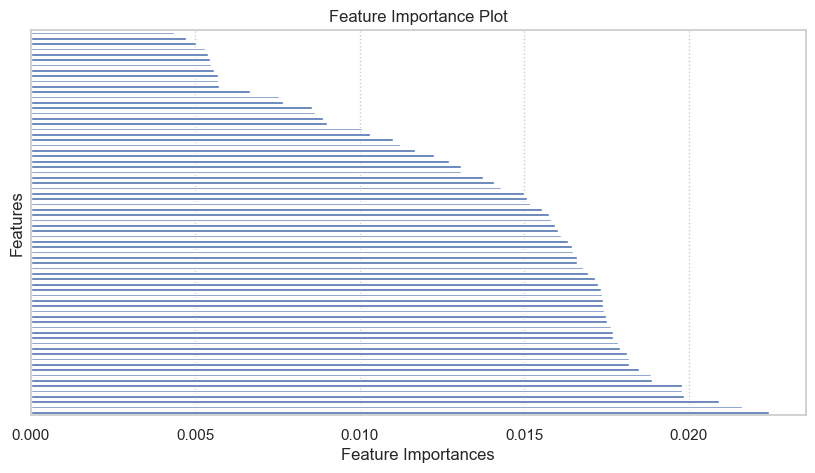

In [82]:
importances.plot(kind = 'barh', figsize = (10, 5))
plt.yticks([])
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("Feature Importance Plot")

As we can see, individual features affect a rather small percentage of variables. However, the plot shows that about 25% of the features (least important ones) don't contribute much to the model. Since using a lower number of features would make the model more explainable and less prone to overfitting, it would make sense to check if dropping the least important features (25%) would affect model scores.

In [87]:
n = int(len(features)*0.75)                           # choose 70% of the features
features_to_keep = list(features[1:n].index)        # keep n most imporartant features
features_to_keep.append('target')                    # include response variable
features_to_keep.append('ID')                       # include ID for future prediction

# create copy of the original data frame with only 20 most important variables plus response; check if it does as well.
df_new = df[features_to_keep].copy()

Below is a list of the 20 most important features, as found out by XGBoost.  In the next project, I will compare this list to the list produced by Principal Component Analysis. It will be shown that there is definitely overlap between features discoverd by these methodologies, even though the results are not an exact match.

In [90]:
# check out the list of 20 most important features:
top10 = list(features[1:20].index)
top10

['tot_spend_last_365',
 'net_lifetime_discount_amt',
 'avg_lag',
 'ordLast1095',
 'spendLast1095',
 'csTimeOnSite30Days',
 'csTimeOnSite15Days',
 'lifetime_discount_amt',
 'net_lifetime_revenue',
 'direct_lifetime_revenue',
 'retail_last_purchase_pipe',
 'csTimeOnSite60Days',
 'direct_first_purchase_pipe',
 'upt',
 'aov',
 'net_lifetime_margin',
 'first_180_day_spend',
 'direct_aov',
 'tot_ord_last_365']

In [92]:
# Split new data set on Train and Test and check if the best score achieved by XGboost is better:
Y = df_new['target']
X = df_new.drop(['target'], axis = 1)

random_state=64
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = random_state)

CustomerID = X_test['ID']                                # remove ID from Train and Test
X_train.drop(['ID'], axis = 1, inplace = True)
X_test.drop(['ID'], axis = 1, inplace = True)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8227, 53), (2057, 53), (8227,), (2057,))

In [94]:
opt = optimizeXGBoost(X_train, Y_train)

pos_weight: 1.454818744473917

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Elapsed time: 59.2001 seconds
Best parameters found:  OrderedDict([('colsample_bylevel', 0.5216600029793866), ('colsample_bytree', 0.05435602973134512), ('gamma', 5.766274493519536e-09), ('learning_rate', 0.024569184108529034), ('max_delta_step', 7), ('max_depth', 5), ('min_child_weight', 2), ('n_estimators', 3839), ('reg_alpha', 1.3321574348548206e-08), ('reg_lambda', 0.32633594034878133), ('subsample', 0.5114186528316955)])
Best score found:  0.4217283704184106


We see the model performs as well if not better with a reduced number of features. Multiple runs of the model would show that small differences present are most likely stochastic. So, for predictions, I will be using the model with a reduced number of features, as was discovered by the optimization process.

#### 3. Make prediction on Test data:
The model will be predicting the probability (propensity) of conversion on Test data.  The folowing printout shows the predicted probabilites and associated metrics for different probability thresholds. 

In [98]:
# Predict on X_test.  The output is the 2 dimentional list;
# with tuples: [Prob of event NOT happening, Prob of event happening]
Y_pred = opt.predict_proba(X_test)



In [100]:
# Define Print_Threshold_Scores Function:

def print_result(prediction_proba):
    threshold = []
    f1_score = []
    precision_score = []
    recall_score = []
    true_positive = []
    false_positive = []
    false_negative = []
    true_negative = []
    
    
    tp=0
    fp=0
    fn=0
    tn=0
    
    def precision(tp,fp):
        if (tp+fp) == 0:
            return 0
        return tp/(tp+fp)

    def recall(tp,fn):
        if (tp+fn) == 0:
            return 0
        return tp/(tp+fn)
               
    def f1(precision,recall):
        if (precision+recall) == 0:
            return 0
        return 2*(precision*recall)/(precision+recall)

    for j in np.flip(np.arange(0, 1, 0.1)):
        print(f"Threshold: {j:0.4f}")  
        threshold.append(j.round(1))
        for i in range(len(prediction_proba)):
            
            if Y_pred[i][1] > j:
                
                if Y_test.iloc[i] == 1:
                    tp+=1
                else:
                    fp+=1
            else:
                if Y_test.iloc[i] == 1:
                    fn+=1
                else:
                    tn+=1
                    #pass
    
    
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        
        pr = precision(tp, fp)
        rc = recall(tp,fn)
        
        print(f"Precision: {pr:0.4f}")
        print(f"Recall: {rc:0.4f}")
        print(f"F1: {f1(precision(tp,fp),recall(tp,fn)):0.4f}")
        score = f1(precision(tp,fp),recall(tp,fn))
        
        f1_score.append(score)
        precision_score.append(pr)
        recall_score.append(rc)
        true_positive.append(tp)
        false_positive.append(fp)
        false_negative.append(fn)
        true_negative.append(tn)
        
    
        tp=0
        fp=0
        fn=0

        tn=0
    
        print()
    return threshold, f1_score, precision_score, recall_score, true_positive, false_positive, false_negative, true_negative

In [102]:
threshold, f1_score, precision_score, recall_score, true_positive, false_positive, false_negative, true_negative = print_result(Y_pred)

Threshold: 0.9000
True Positives: 29
False Positives: 3
False Negatives: 627
Precision: 0.9062
Recall: 0.0442
F1: 0.0843

Threshold: 0.8000
True Positives: 64
False Positives: 21
False Negatives: 592
Precision: 0.7529
Recall: 0.0976
F1: 0.1727

Threshold: 0.7000
True Positives: 102
False Positives: 64
False Negatives: 554
Precision: 0.6145
Recall: 0.1555
F1: 0.2482

Threshold: 0.6000
True Positives: 158
False Positives: 127
False Negatives: 498
Precision: 0.5544
Recall: 0.2409
F1: 0.3358

Threshold: 0.5000
True Positives: 229
False Positives: 235
False Negatives: 427
Precision: 0.4935
Recall: 0.3491
F1: 0.4089

Threshold: 0.4000
True Positives: 329
False Positives: 403
False Negatives: 327
Precision: 0.4495
Recall: 0.5015
F1: 0.4741

Threshold: 0.3000
True Positives: 440
False Positives: 643
False Negatives: 216
Precision: 0.4063
Recall: 0.6707
F1: 0.5060

Threshold: 0.2000
True Positives: 562
False Positives: 922
False Negatives: 94
Precision: 0.3787
Recall: 0.8567
F1: 0.5252

Thresho

Text(0.5, 1.0, 'Threshold vs F1 Score')

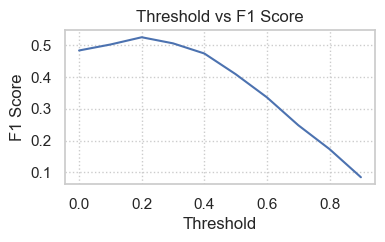

In [104]:
# Plot threshold vs F1 score
plt.figure(figsize = (4,2))
plt.plot(threshold, f1_score)
plt.xlabel ('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')

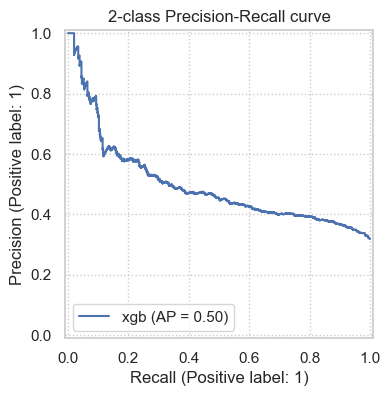

In [106]:
# Plot Precision - Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
sns.set(rc ={'figure.figsize': (6,4)})
sns.set_style('whitegrid', {'grid.linestyle':':'})


display = PrecisionRecallDisplay.from_estimator(
    opt, X_test, Y_test, name="xgb"#, plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

As we will see, the balance between Precision and Recall (F1 score) is much better for the lower thresholds. F1 score peaks at 0.2, which is too low for sucessfull classification. Ideally, we would want to have viable metrics for the 0.5 threshold.

#### 4. Visualize the Results:

In [110]:
# Create Precision / Recall data frame
df_precision = pd.DataFrame({'Threshold': threshold, 'Score': precision_score, 'Precision/Recall': 'Precision'})
df_recall = pd.DataFrame({'Threshold': threshold, 'Score': recall_score, 'Precision/Recall': 'Recall'})
df_precision_recall = pd.concat([df_precision, df_recall])
#df_precision_recall

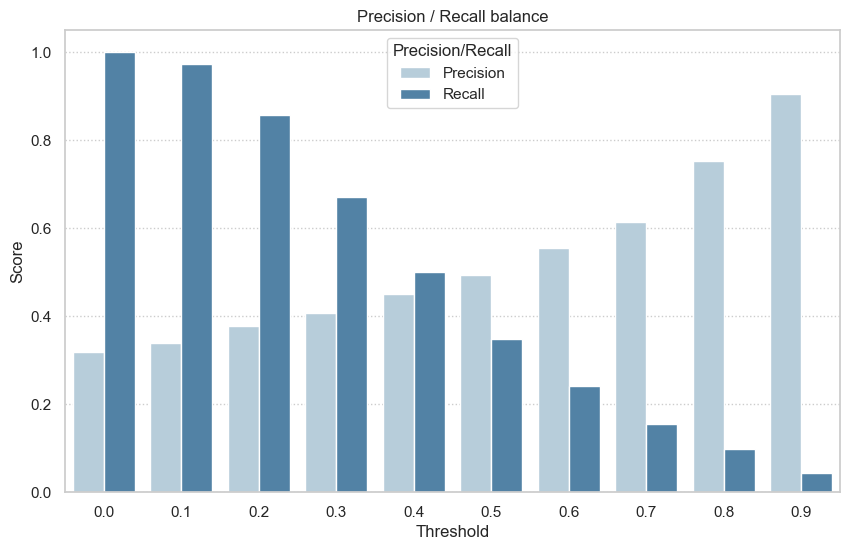

In [112]:
sns.set(rc ={'figure.figsize': (10,6)})
sns.set_style('whitegrid', {'grid.linestyle':':'})
sns.barplot(data = df_precision_recall, x = 'Threshold', y = 'Score', hue = 'Precision/Recall', saturation = 0.6, palette = 'Blues')
plt.title('Precision / Recall balance')
plt.show()

In [114]:
df_true_positive = pd.DataFrame({'Threshold': threshold, 'Count': true_positive, 'True/False': 'True Positive'})
df_false_positive = pd.DataFrame({'Threshold': threshold, 'Count': false_positive, 'True/False': 'False Positive'})
df_true_negative = pd.DataFrame({'Threshold': threshold, 'Count': true_negative, 'True/False': 'True Negative'})
df_false_negative = pd.DataFrame({'Threshold': threshold, 'Count': false_negative, 'True/False': 'False Negative'})
df_true_false = pd.DataFrame()
df_true_false = pd.concat([df_true_positive, df_false_positive, df_true_negative, df_false_negative])
#df_true_false

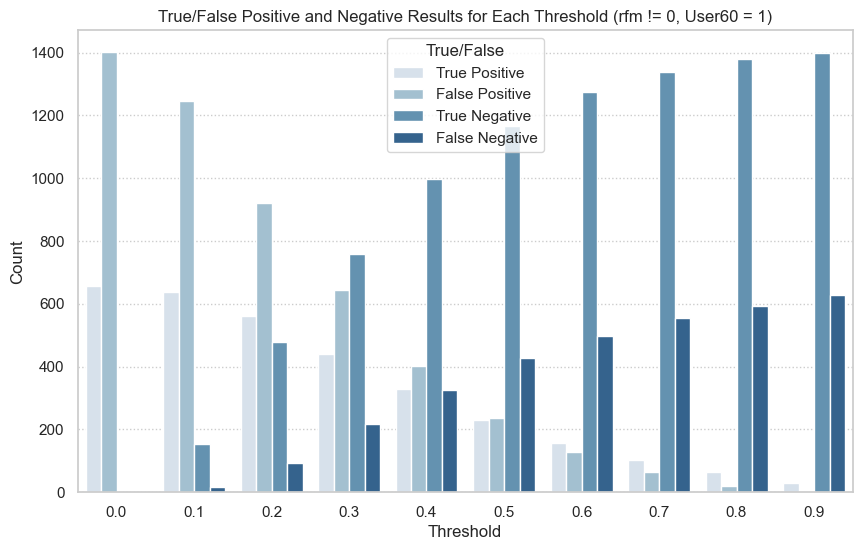

In [116]:
sns.barplot(data = df_true_false, x = 'Threshold', y = 'Count', hue = 'True/False', saturation = 0.6, palette = 'Blues')
plt.title('True/False Positive and Negative Results for Each Threshold (rfm != 0, User60 = 1)')
plt.show()

In [118]:
from sklearn import metrics
from numpy import matrix

In [120]:
predictions = matrix(Y_pred).transpose()[1].getA()[0]
predictions

array([0.5618135 , 0.07406094, 0.7594038 , ..., 0.1145884 , 0.22162445,
       0.64604115], dtype=float32)

In [122]:
low = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
high = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
label_list = ['0.1 -  0.2', '0.2 - 0.3', '0.3 - 0.4', '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0']

In [124]:
df_prediction = pd.DataFrame({'Customer': CustomerID, 'Observed': Y_test, 'Predicted': predictions})
df_prediction['PTB Bucket'] = '0 - 0.1'

for l, h, label in zip(low, high, label_list):
    df_prediction.loc[(df_prediction['Predicted'] >= l) & (df_prediction['Predicted'] < h), 'PTB Bucket'] = label
    
    

In [126]:
df_prediction.head()

,Customer,Observed,Predicted,PTB Bucket
326,224969738,1,0.561813,0.5 - 0.6
7349,226558936,0,0.074061,0 - 0.1
10278,194236864,1,0.759404,0.7 - 0.8
1139,4357760,0,0.208326,0.2 - 0.3
9614,17893107,0,0.382738,0.3 - 0.4


In [128]:
buckets = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4', '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1']

In [130]:
df_counts = df_prediction.groupby('PTB Bucket')['Customer'].count()
customer_count = []
for i in range(10):
    count = df_counts.iloc[i]
    customer_count.append(count)

In [132]:
df_observed = df_prediction.groupby('PTB Bucket')['Observed'].sum()
observed_sum = []
for i in range(10):
    observed = df_observed.iloc[i]
    observed_sum.append(observed)

##### Create data frames for Number of Customers and Percentage of Converted Customers in Propensity Groups:

In [135]:
dff = pd.DataFrame({'Propensity Group': buckets, 'Customer Count': customer_count, 'Converted Customers': observed_sum})
dff['% Customer Count'] = round(dff['Customer Count']/ dff['Customer Count'].sum(), 3)
dff['% Converted Customers in the Group'] = round(dff['Converted Customers'] / dff['Customer Count'], 2)

In [137]:
df_customers = dff.drop(['% Customer Count', '% Converted Customers in the Group'], axis = 1)


Text(0, 0.5, 'Customer Count in the Group')

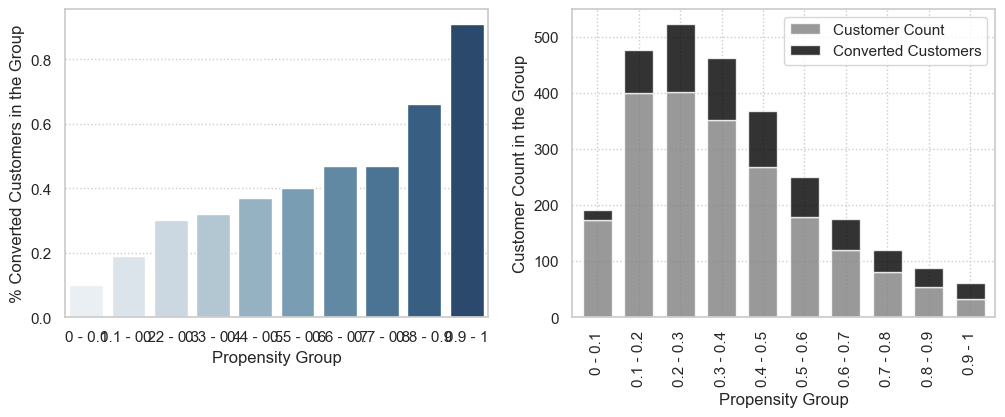

In [139]:
sns.set(rc ={'figure.figsize': (12,4)})
sns.set_style('whitegrid', {'grid.linestyle':':'})

fig, (ax1, ax2) = plt.subplots(ncols = 2)
sns.barplot(data = dff, x = 'Propensity Group', y = '% Converted Customers in the Group', saturation = 0.5, palette = 'Blues', ax = ax1)
df_customers.set_index('Propensity Group').plot(kind = 'bar', stacked = True, color = ['gray','black'], alpha = 0.8, width = 0.7, ax = ax2)
ax2.set_ylabel("Customer Count in the Group")



#### 5. Conclusion:
As we can see on the plots, the model produced more accurate conversion results for customers in higher propensity groups.  For example, for the group with a 0.9 and higher propensity as predicted by the model, the actual conversion rate was over 80%.  However, for the groups with lower predicted propensity (but still greater than 0.5), the actual conversion rate was lower. As was mentioned above, the greatest F1 score was achieved at only a 0.2 threshold. For a 0.4 threshold, the score was slightly lower, and for a 0.5 threhold, the difference was noticeable. Notice that the graph shows that the smallest difference between Precision and Recall occurs for thresholds around 0.4 and 0.5.

Testing the model on real-time, new data using a 0.4 threshold as a cutoff between 'buy' and 'no-buy' produced rather positive results. However, it makes sense to keep looking for ways to see if additional improvements can be made.

In the following projects, I will explore other approaches to this problem.
